In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ActionChains

import time
import random

import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow import keras
import cv2

In [22]:
model = keras.models.load_model('model_keras_classif_2')

# Real Env

In [23]:
class LinkedInGame:
    def __init__(self):
        self.result = None
        self.still_playing = True
        self.browser = webdriver.Chrome('chromedriver.exe');
        self.browser.get('https://iframe-auth.arkoselabs.com/7240EEE3-B753-6DA3-999D-2FBE6C507073/index.html?mkt=en');
        time.sleep(7) # move to start game, and have something smart to check button 'verify' is there
        
    def start_game(self):
#         wait = WebDriverWait(self.browser, 10)
#         iframe = wait.until(EC.presence_of_element_located((By.ID, "fc-iframe-wrap")))
#         self.browser.switch_to.frame(iframe)
        self.browser.switch_to.frame(self.browser.find_element_by_id('fc-iframe-wrap'))
        btn = self.browser.find_element_by_id('triggerLiteMode')
#         wait = WebDriverWait(self.browser, 10)
#         btn = wait.until(EC.presence_of_element_located((By.ID, "triggerLiteMode")))
        ac = ActionChains(self.browser)
        ac.move_to_element(btn).move_by_offset(0, 0).click().perform()
        time.sleep(5) # do something smart for this wait
        self.browser.switch_to.frame(self.browser.find_element_by_id('CaptchaFrame'))
        
    def get_state(self):
        screenshot_data = self.browser.get_screenshot_as_png()
        screen_img = Image.open(io.BytesIO(screenshot_data))
        screen_array = np.asarray(screen_img)
        screen_array = cv2.cvtColor(screen_array, cv2.COLOR_BGR2GRAY)
        screen_array = screen_array[0:750, 0:750]
        screen_array = screen_array[208:488, 237:517]
        screen_array = cv2.resize(screen_array, (48,48))
        screen_array = np.expand_dims(screen_array, axis=2)
        screen_array = screen_array.astype('float32')
        screen_array /= 255
        return np.array([screen_array])
        
    def get_available_moves(self):
        # Implement properly
        return [-1, 1, 0]
    
    def make_move(self, move):
        # 1: clockwise, -1: anticlockwise, 0: Done
        if move == 1:
            try:
                canv = self.browser.find_element_by_id('FunCAPTCHA')
                ac = ActionChains(self.browser)
                ac.move_to_element(canv).move_by_offset(-75, 0).click().perform()
            except:
                self.check_result()
        elif move == -1:
            try:
                canv = self.browser.find_element_by_id('FunCAPTCHA')
                ac = ActionChains(self.browser)
                ac.move_to_element(canv).move_by_offset(75, 0).click().perform()
            except:
                self.check_result()
        else:
            try:
                canv = self.browser.find_element_by_id('FunCAPTCHA')
                ac = ActionChains(self.browser)
                ac.move_to_element(canv).move_by_offset(0, 90).click().perform()
            except:
                self.check_result()
                
    def check_result(self):
        """
        TODO: To avoid the agent making a move after its already lost the first round:
              consider adding a check for CaptchaFrame2 here and running the check after every move
        """
        # Check what frame we're in here...
        self.browser.switch_to.parent_frame()
        #check for text
        success_div = self.browser.find_element_by_class_name('success')
        if success_div.value_of_css_property('display') != 'none':
            self.still_playing = False
            self.result = 'Won'
        else:
            self.still_playing = False
            self.result = 'Lost'

In [24]:
pred_map = {0:0, 
            1:-1, 
            2:1}

[3.7107714e-06 9.9436897e-01 5.6273541e-03]


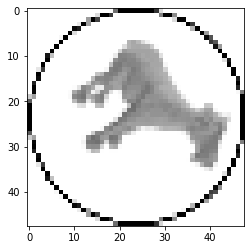

-1
[0.9529662  0.00277311 0.04426067]


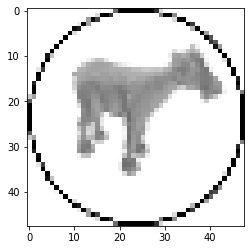

0
[1.7289229e-05 9.3684852e-01 6.3134231e-02]


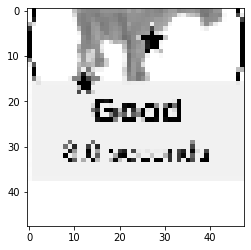

-1
[0.37916028 0.2221056  0.39873415]


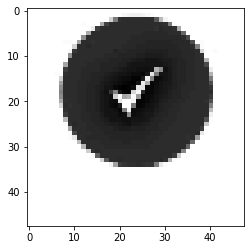

1
Game result: Won


In [26]:
li_game = LinkedInGame()
li_game.start_game()

i = 0

while li_game.still_playing:
    
    state_img = li_game.get_state()
#     move_set = li_game.get_available_moves()
    pred_id = model.predict(state_img)[0]
    print(pred_id)
    pred_id = np.argmax(pred_id)
    
    chosen_move = pred_map[pred_id]
#     chosen_move = random.choice(move_set) # someone's gotta learn this...
    
    plt.figure()
    plt.imshow(state_img[0][:, :, 0], cmap='gray')
    plt.show()
    
    print(chosen_move)
    
    li_game.make_move(chosen_move)
    time.sleep(1)
    
    i+=1
    
print("Game result:", li_game.result)